# <font color=blue>Chapter 1:  Exploring graphs through time</font>

#### Finding Dyads and Triads
Let's think a little bit more about what we can learn from dyad and triad censuses of the overall graph. Because we are interested in understanding how items are purchased together and whether or not they are reciprocally purchased, dyad and triad censuses can provide a useful initial look. A dyad census will tell us how many items are purchased reciprocally vs. asymmetrically. The triad census will tell us which items might be important, specifically patterns 4, 5, 9, and 12. All of these have one vertex that has 2 out degree edges and no in degree edges. Edge density should also give some insight we expect for graph clustering.

In [2]:
library(igraph)
library(dplyr) 


amzn_g <- read.graph("amzn_g.gml",format=c("gml"))

# Perform dyad census
dc <- dyad_census(amzn_g)

# Perform triad census
tc <- triad_census(amzn_g)

# Find the edge density
ed <- edge_density(amzn_g)

# Output values
print(dc)
print(tc)
print(ed)


Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union


Attaching package: 'dplyr'

The following objects are masked from 'package:igraph':

    as_data_frame, groups, union

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



$mut
[1] 3199

$asym
[1] 4356

$null
[1] 52467335

 [1] 179089386743     44610360     32763436          215         1906
 [6]          507         1198          457          118            0
[11]          301          170          119           33          239
[16]          288
[1] 0.0001024681


#### Clustering and Reciprocity
Our previous work looking at the dyad census should give some intuition about how we expect other graph level metrics like reciprocity and clustering in our co-purchase graph to look. Recall that there are 10, 245 edges in our graph of 10, 754 vertices, and of those, more than 3, 000 are mutual, meaning that almost 60 percent of the vertices have a mutual connection. What do you expect the clustering and reciprocity measures to look like given this information? We can test our intuition against a null model by simulating random graphs. In light of the results of our previous simulation, what do you expect to see here? Will reciprocity also be much higher than expected by chance?

In [3]:
# Calculate transitivity
transitivity(amzn_g)

# Calculate reciprocity
amzn_rp <- reciprocity(amzn_g)

# Simulate our outputs
nv <- gorder(amzn_g)
ed <- edge_density(amzn_g)
rep_sim <- rep(NA, 1000)

# Simulate 
for(i in 1:1000){
  rep_sim[i] <- reciprocity(erdos.renyi.game(nv, ed, "gnp", directed = T))
}

# Compare
quantile(rep_sim, c(0.25, .5, 0.975))
print(amzn_rp)

[1] 0.3875752

25%          50%        97.5% 
0.0000000000 0.0000000000 0.0003790418

[1] 0.5949414


#### Important Products
We've now seen that there's a clear pattern in our graph. Let's take the next step and move beyond just understanding the structure. Given the context of graph structure, what can we learn from it? For example, what drives purchases? A place to start might be to look for "important products", e.g. those products that someone purchases and then purchases something else. We can make inferences about this using in degree and out degree. First, we'll look at our graph and see the distribution of in degree and out degree, and then use that to set up a working definition for what an "important product" is (something that has > X out degrees and < Z in degrees). We'll then make a subgraph to visualize what these subgraphs look like.

In [4]:
# Get the distribution of in and out degrees
table(degree(amzn_g, mode = "in"))
table(degree(amzn_g, mode = "out"))

# Find important products based on the ratio of out to in and look for extremes
imp_prod <- V(amzn_g)[degree(amzn_g, mode = "out") > 3 & degree(amzn_g, mode = "in") < 3]

## Output the vertices
print(imp_prod)


   0    1    2    3    4    5    6    7    8    9   11   12   17 
2798 5240 1549  424  139   50   20    7    9    5    1    2    1 


   0    1    2    3    4    5 
1899 6350 1635  313   45    3 

+ 8/10245 vertices, named, from 5a5167a:
[1] 1629   4545   6334   20181  62482  64344  155513 221085


#### What Wakes an Important Product?
Now that we've come up with a working definition of an important product, let's see if they have any properties that might be correlated. One candidate pairing is salesrank.from and salesrank.to. We can ask if important products tend to have higher sales ranks than the products people purchase downstream. We'll look at this by first subsetting out the important vertices, joining those back to the initial dataframe, and then creating a new dataframe using the package dplyr. We'll create a new graph, and color the edges blue for high ranking (1, 2, 3) to low ranking (20, 21, 22) and red for the opposite. If rank is correlated with downstream purchasing, then we'll see mostly blue links, and if there's no relationship, it will be about equally red and blue.

The dataset ip_df contains the information about important products.

In [5]:
# Create a new graph
ip_g <- graph_from_data_frame(ip_df %>% select(from, to), directed = T)

# Add color to the edges based on sales rank, blue is higer to lower, red is lower to higher
E(ip_g)$rank_flag <- ifelse(ip_df$salesrank.from <= ip_df$salesrank.to, "blue", "red")

# Plot and add a legend
plot(ip_g, vertex.label = NA, edge.arrow.width = 1, edge.arrow.size = 0, 
    edge.width = 4, margin = 0, vertex.size = 4, 
    edge.color = E(ip_g)$rank_flag, vertex.color = "black" )
legend("bottomleft", legend = c("Lower to Higher Rank", "Higher to Lower Rank"), 
       fill = unique(E(ip_g)$rank_flag ), cex = .7)

ERROR: Error in eval(lhs, parent, parent): Objekt 'ip_df' nicht gefunden


#### Metrics Through Time
So far, we have been looking at products that drive other purchases by examining their out degree. However, up until the last lesson we've just been looking at a single snapshot in time. One question is, do these products show similar out degrees at each time step? After all, a product driving other purchases could just be idiosyncratic, or it if were more stable through time it might indicate that product could be responsible for driving co-purchases. To get at this question, we're going to build off the code we've already walked through that generates a list with a graph at each time step.

In [4]:
# Get unique Dates
d <- sort(unique(amzn_raw$date))
# Create graph from first date.
amzn_g <- graph_from_data_frame(amzn_raw %>% filter(date ==d[1]) %>%
select(from, to), directed = T)
# Find products that are "important".
imp_prod <- V(amzn_g)[degree(amzn_g, mode = "out") > 2 &
degree(amzn_g, mode = "in") < 1]
# Store as a data frame to later join on.
tmp_df <- data.frame("imp_prod" = as.numeric(names(imp_prod)))

## Create list to hold output
time_graph <- list()
## Create a 2x2 layout for plots and increase margins
par(mfrow = c(2, 2), mar = c(1.1, 1.1, 1.1, 1.1))
## Loop over the data to build
for(i in 1:length(d)){
## Create a data frame at each time stamp
ip_df <- amzn_raw %>% filter(date == d[i]) %>% right_join(tmp_df, by = c("from" = "imp_prod")) ## Create an igraph object from that data frame
time_graph[[i]] <- graph_from_data_frame(ip_df %>% select(from, to), directed = T)
## Plot it, to see how what important vertices look like at each date
plot(time_graph[[i]], vertex.label = NA, edge.arrow.width = .8, edge.arrow.size = .3, edge.width }

ERROR: Error in parse(text = x, srcfile = src): <text>:22:98: Unerwartete(s) '}'
21: ## Plot it, to see how what important vertices look like at each date
22: plot(time_graph[[i]], vertex.label = NA, edge.arrow.width = .8, edge.arrow.size = .3, edge.width }
                                                                                                     ^


[[1]]
+ 3/126 vertices, named, from 38ecae2:
[1] 1629   62482  221085

[[2]]
+ 2/49 vertices, named, from dfcddfb:
[1] 52831  132757

[[3]]
+ 2/65 vertices, named, from ed0a1b9:
[1] 123808 132757

[[4]]
+ 1/50 vertex, named, from ad9b8e6:
[1] 1629


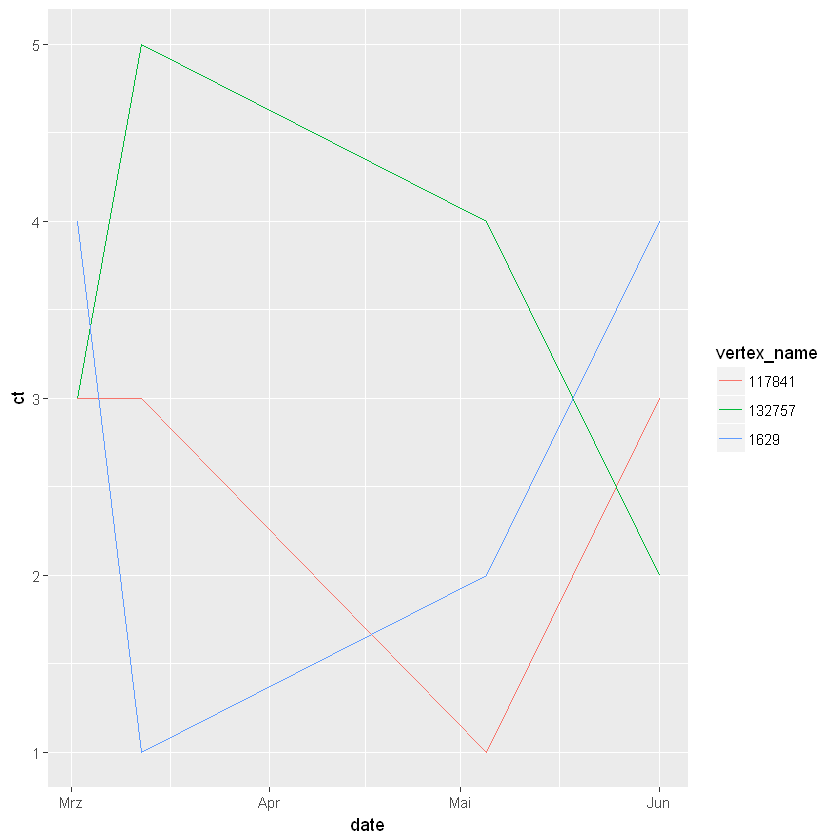

In [10]:
library(lubridate)
library(ggplot2)
d <- c("2003-03-02", "2003-03-12", "2003-05-05", "2003-06-01")

time_graph <- readRDS("time_graph.rds")
# Get a count of out degrees for all vertices
deg_ct <- lapply(time_graph, function(x){return(degree(x, mode = "out") )})

# Create a dataframe starting by adding the degree count
deg_df <- data.frame(ct = unlist(deg_ct))

# Add a column with the vertex names 
deg_df$vertex_name <- names(unlist(deg_ct))

# Add a time stamp 
deg_df$date <- ymd(rep(d, unlist(lapply(time_graph, function(x){length(V(x))}))))

# See all the vertices that have more than three out degrees
lapply(time_graph, function(x){return(V(x)[degree(x, mode = "out") > 3])})

# Create a dataframe to plot of three important vertices
vert_df <- deg_df %>% filter(vertex_name %in% c(1629, 132757, 117841))

# Draw the plot to see how they change through time
ggplot(vert_df, aes(x = date, y = ct, group = vertex_name, colour = vertex_name)) + geom_path()

#### Plotting Metrics Over Time
We can also examine how metrics for the overall graph change (or don't) through time. Earlier we looked at two important ones, clustering and reciprocity. Each were quite high, as we expected after visually inspecting the graph structure. However, over time, each of these might change. Are global purchasing patterns on Amazon stable? If we think so, then we expect plots of these metrics to essentially be horizontal lines, indicating that reciprocity is about the same every day and there's a high degree of clustering structure. Let's see what we can find here.

In [11]:
# Calculate clustering and reciprocity metrics
trans <- unlist(lapply(all_graphs, transitivity))
rp <- unlist(lapply(all_graphs, reciprocity))

# Create daaframe for plotting
met_df <- data.frame("metric" = c(trans, rp))

# Repeat the data
met_df$date <- rep(ymd(d), 2)

# Sort and then Repeat the metric labels
met_df$name <- sort(rep(c("clustering", "reciprocity"), 4))

# Plot
ggplot(met_df, aes(x= date, y= metric, group = name, colour = name)) + geom_path()

ERROR: Error in lapply(all_graphs, transitivity): Objekt 'all_graphs' nicht gefunden


In [2]:
%%lsmagic

ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: Unerwartete(s) SPECIAL
1: %%
    ^
